In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('reg.csv', index_col=[0])
df.head(10) 

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
5,0.038651,0.019568,0.139449,0.719852,0.560581,0.610531,0.578661,0.387926,0.133629,0.072967,0.514078,0.986385,0.127396,0.526667
6,0.033301,0.136658,0.336651,0.274996,0.472140,0.331155,0.643546,0.661869,0.270651,0.239929,0.475964,0.993516,0.300521,0.397778
7,0.026858,0.151993,0.300627,0.115449,0.463345,0.532618,0.938389,0.465781,0.139893,0.238901,0.243669,0.991425,0.431171,0.491111
8,0.021739,0.132378,0.259349,0.488716,0.389581,0.411536,0.984672,0.526151,0.201324,0.236329,0.306712,0.965204,0.767177,0.255556
9,0.014588,0.144471,0.331099,0.759479,0.696532,0.334544,0.834204,0.611416,0.174935,0.237351,0.437982,0.967070,0.445798,0.308889


In [3]:
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1,1))

In [4]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [6]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
      
        return x

In [7]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [8]:
loss_ = []
n = len(trainloader)

for epoch in range(400):

    running_loss = 0.0

    for data in trainloader:

        inputs, values = data
       
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_.append(running_loss/n)



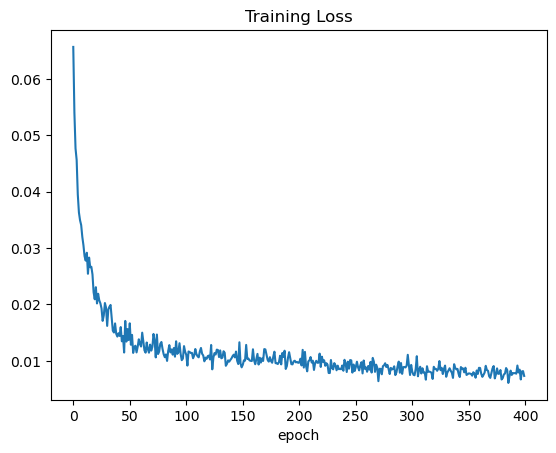

In [9]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [10]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)
        
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0)
            actual = torch.cat((actual, values), 0)
    
    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    
    return rmse

In [11]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

Train RMSE:  0.06699440802294504
Test RMSE:  0.11686353407934875
